# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [8]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [9]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

/Users/haitao/.pyenv/versions/3.11.6/envs/smax/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/haitao/.pyenv/versions/3.11.6/envs/smax/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/haitao/.pyenv/versions/3.11.6/envs/smax/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/haitao/.pyenv/versions/3.11.6/envs/smax/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, app

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279244 entries, 0 to 279243
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Request ID                279240 non-null  object        
 1   Title                     279236 non-null  object        
 2   Created Time              279236 non-null  datetime64[ns]
 3   Customer Company          279032 non-null  object        
 4   Customer Country          279115 non-null  object        
 5   Priority                  279236 non-null  object        
 6   Urgency                   279236 non-null  object        
 7   Impact                    279236 non-null  object        
 8   Product Name              278492 non-null  object        
 9   Module Name               266790 non-null  object        
 10  Service Definition        279210 non-null  object        
 11  Service Desk Group        278104 non-null  object        
 12  St

In [10]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

Escalated To Engineering    271959
Bug Type                    270404
Status Reason               259058
Escalated to L2             258442
Category                    100740
Completion Code              26558
Module Name                  12454
Closed Time                   2787
Service Desk Group            1140
Product Name                   752
Customer Company               212
Customer Country               129
Service Definition              34
Contracts Reference             13
Creation Source                  8
Resolution Time (Min)            8
Response Time (Min)              8
Status                           8
Title                            8
Impact                           8
Urgency                          8
Priority                         8
Created Time                     8
Request ID                       4
dtype: int64

In [11]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [12]:
df_combined.isnull().sum().sort_values(ascending = False)

Module Name              10715
Closed Time               2561
Service Desk Group        1030
Customer Company           179
Customer Country           100
Service Definition           9
Contracts Reference          5
Resolution Time (Min)        0
Response Time (Min)          0
Status                       0
Request ID                   0
Title                        0
Product Name                 0
Impact                       0
Urgency                      0
Priority                     0
Created Time                 0
Creation Source              0
dtype: int64

In [13]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [14]:
data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168829 entries, 0 to 168828
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             168829 non-null  int64         
 1   Title                  168829 non-null  object        
 2   Created Time           168829 non-null  datetime64[ns]
 3   Customer Company       168650 non-null  object        
 4   Customer Country       168729 non-null  object        
 5   Priority               168829 non-null  object        
 6   Urgency                168829 non-null  object        
 7   Impact                 168829 non-null  object        
 8   Product Name           168829 non-null  object        
 9   Module Name            158114 non-null  object        
 10  Service Definition     168820 non-null  object        
 11  Service Desk Group     167799 non-null  object        
 12  Status                 168829 non-null  obje

In [15]:
df_processed = df_combined.copy()
df_processed['Length'] = 0
df_processed['Language']=pd.NA
df_processed['Title_Processed']=pd.NA
df_processed['Title_Translated']=pd.NA
df_processed['Title_Cleaned']=pd.NA
print(df_processed.info())
df_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168829 entries, 0 to 168828
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             168829 non-null  int64         
 1   Title                  168829 non-null  object        
 2   Created Time           168829 non-null  datetime64[ns]
 3   Customer Company       168650 non-null  object        
 4   Customer Country       168729 non-null  object        
 5   Priority               168829 non-null  object        
 6   Urgency                168829 non-null  object        
 7   Impact                 168829 non-null  object        
 8   Product Name           168829 non-null  object        
 9   Module Name            158114 non-null  object        
 10  Service Definition     168820 non-null  object        
 11  Service Desk Group     167799 non-null  object        
 12  Status                 168829 non-null  obje

,Request ID,Title,Created Time,Customer Company,Customer Country,Priority,Urgency,Impact,Product Name,Module Name,...,Closed Time,Response Time (Min),Resolution Time (Min),Contracts Reference,Creation Source,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1705753,OFM Support,2022-12-14 06:29:13,AL-KHAFJI JOINT OPERATIONS (AGOC/KGOC),NaN,P4 Low,This issue disrupts my work,Single user,OFM,Base,...,2022-12-29 06:30:58,0.0000,0.7150,Standard-Software-Maintenance-Contract,Agent Created Ticket,0,<NA>,<NA>,<NA>,<NA>
1,1130253,Rerun workflow and Create workflow option not ...,2022-01-04 21:52:01,GROUPEMENT REGGANE,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel RE,RE - Other,...,2022-01-10 03:16:58,66.0677,0.0000,Standard-Software-Maintenance-Contract,Support Portal,0,<NA>,<NA>,<NA>,<NA>
2,1130330,[Ext] TR- Registration Completion Notice,2022-01-05 08:07:22,SH - PED,ALGERIA,P4 Low,This issue disrupts my work,Single user,ECLIPSE,Eclipse 100 (Blackoil),...,2022-01-21 08:27:25,37.6989,1402.1556,Standard-Software-Maintenance-Contract,Email,0,<NA>,<NA>,<NA>,<NA>
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,2022-01-05 14:29:47,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Installation,...,2022-01-05 14:32:14,0.0000,3.2456,Standard-Software-Maintenance-Contract,Agent Created Ticket,0,<NA>,<NA>,<NA>,<NA>
4,1131191,SH-PED: issue with ProSource services,2022-01-05 14:34:47,SH - PED,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,ProSource,Administration,...,2022-01-05 14:36:32,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,0,<NA>,<NA>,<NA>,<NA>


# Cleanup Product Name

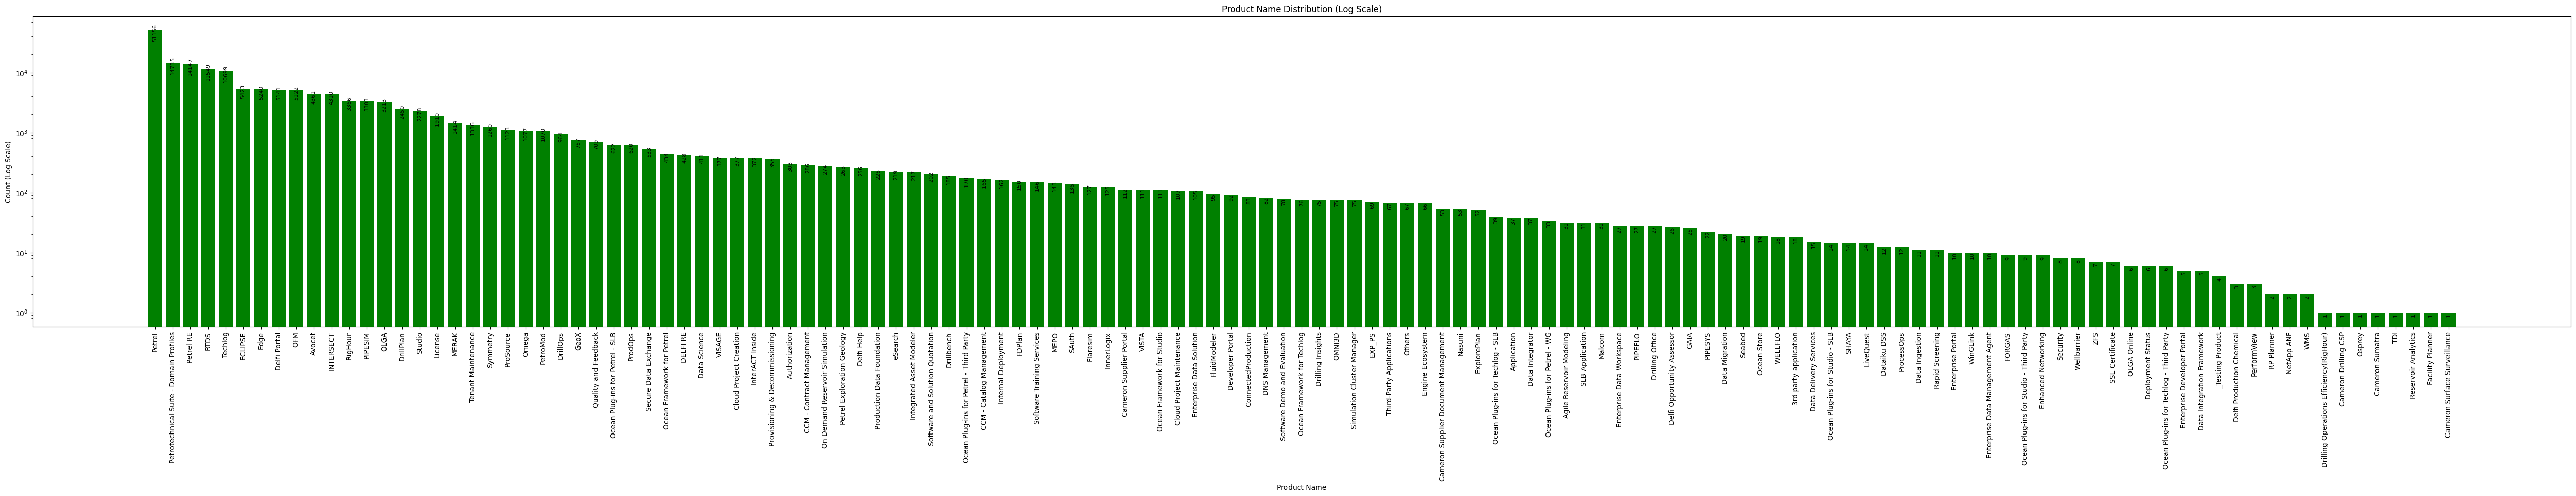

In [16]:
hist_by_labels(df_processed, 'Product Name', log=True, horizontal=True)

<class 'pandas.core.frame.DataFrame'>
Index: 167070 entries, 0 to 168828
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             167070 non-null  int64         
 1   Title                  167070 non-null  object        
 2   Created Time           167070 non-null  datetime64[ns]
 3   Customer Company       166900 non-null  object        
 4   Customer Country       166985 non-null  object        
 5   Priority               167070 non-null  object        
 6   Urgency                167070 non-null  object        
 7   Impact                 167070 non-null  object        
 8   Product Name           167070 non-null  object        
 9   Service Definition     167061 non-null  object        
 10  Service Desk Group     166045 non-null  object        
 11  Status                 167070 non-null  object        
 12  Closed Time            164573 non-null  datetime6

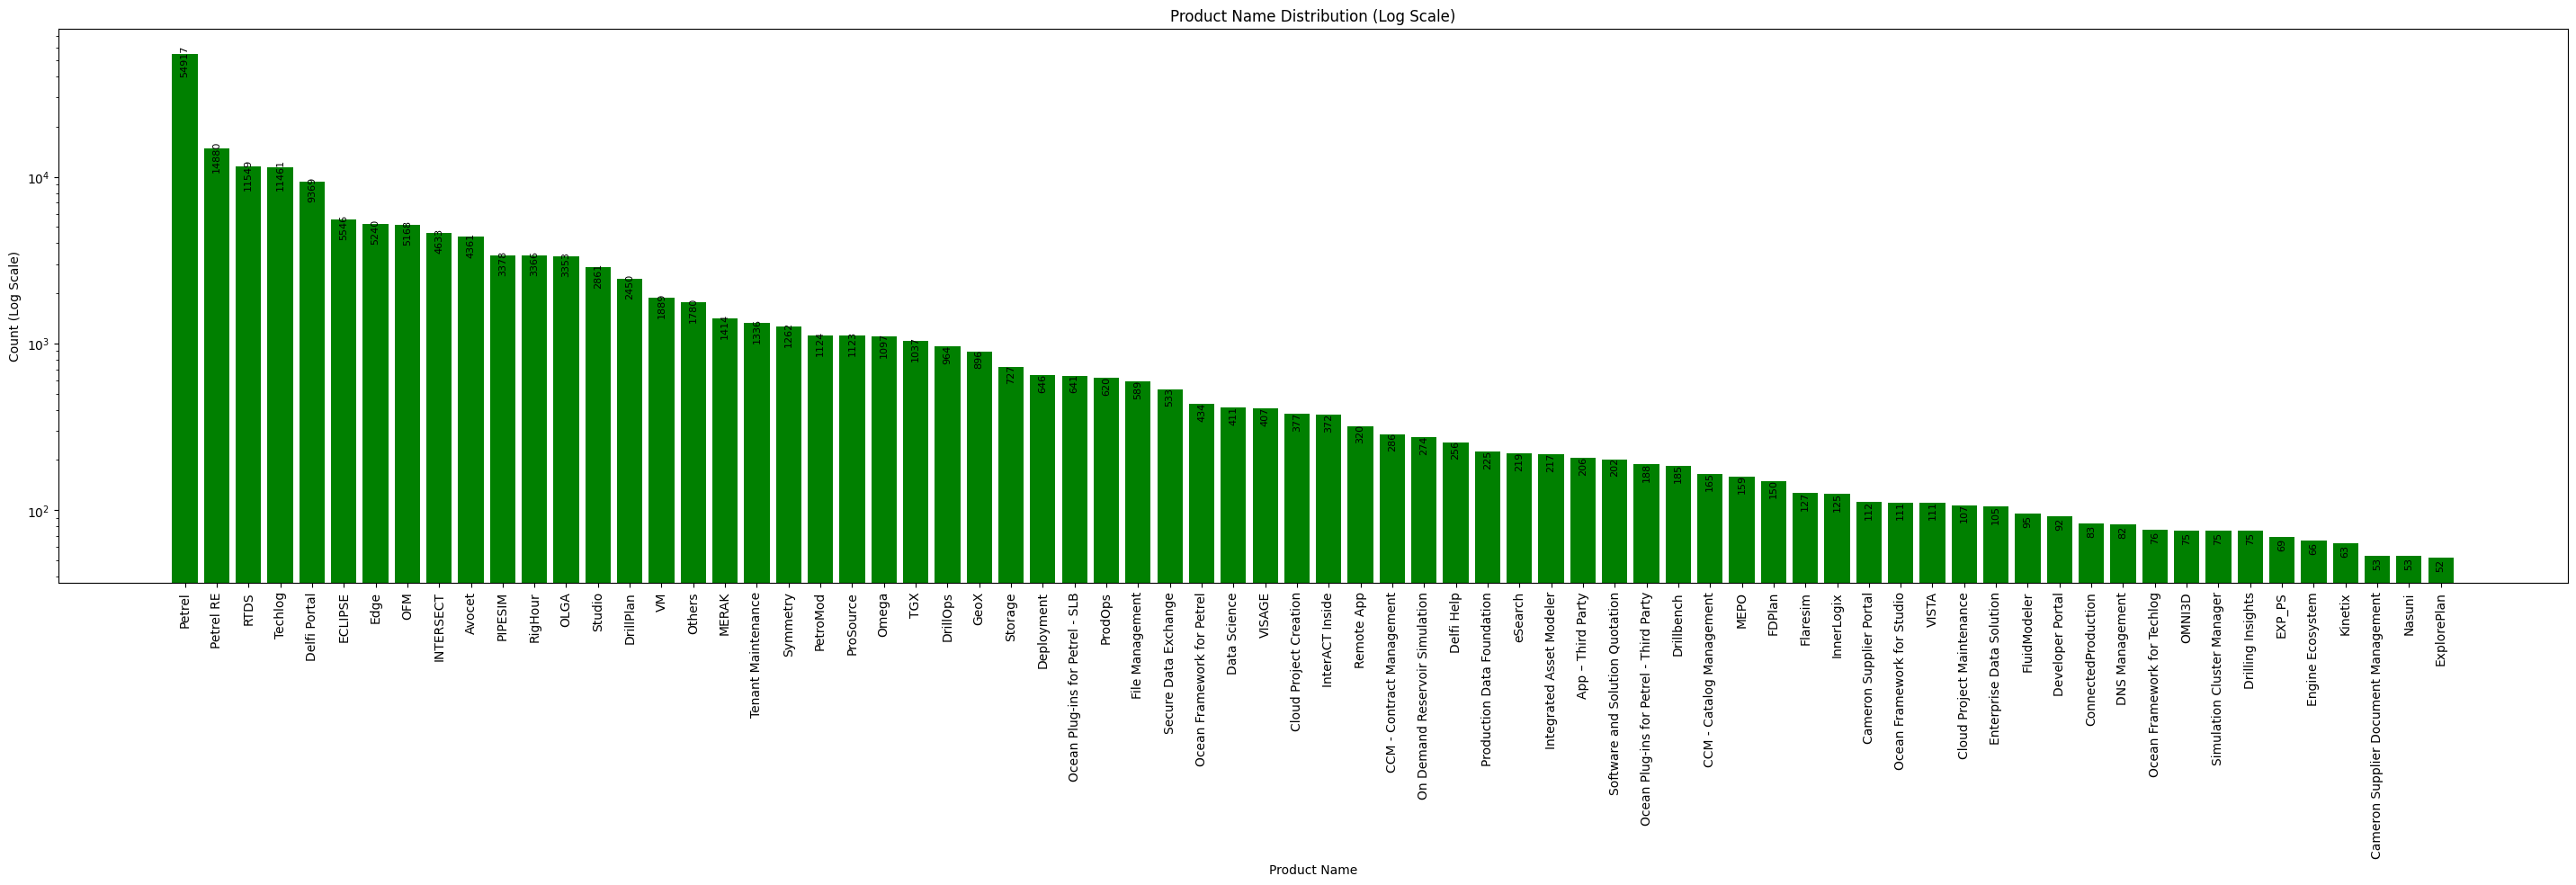

In [17]:
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'
df_processed.loc[df_processed['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_processed['Module Name']
df_processed.drop(columns=['Module Name'], inplace=True)
df_processed.dropna(subset=['Product Name'], inplace=True)

# Consolidate the following products into Petrel
df_processed.loc[df_processed['Product Name'] == 'Petrel Exploration Geology', 'Product Name'] = 'Petrel'
df_processed.loc[df_processed['Product Name'] == 'Petrel Project Explorer', 'Product Name'] = 'Petrel'

# Case of one product has multiple names
df_processed.loc[df_processed['Product Name'] == 'DELFI RE', 'Product Name'] = 'Petrel RE' # Pretel RE --> DELFI RE
df_processed.loc[df_processed['Product Name'] == 'OMEGA', 'Product Name'] = 'Omega' # OMEGA --> Omega
df_processed.loc[df_processed['Product Name'] == 'Other', 'Product Name'] = 'Others' # Other --> Others
df_processed.loc[df_processed['Product Name'] == 'Third-Party Applications', 'Product Name'] = 'App – Third Party' # Third-Party Applications --> App – Third Party
df_processed.loc[df_processed['Product Name'] == 'Ocean Plug-ins for Petrel - Third party', 'Product Name'] = 'Ocean Plug-ins for Petrel - Third Party' # Ocean Plug-ins for Petrel - Third party --> Ocean Plug-ins for Petrel - Third Party

# Consolidate the following products into 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Provisioning & Decommissioning', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Software Demo and Evaluation', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Internal Deployment', 'Product Name'] = 'Deployment'
df_processed.loc[df_processed['Product Name'] == 'Image', 'Product Name'] = 'Deployment'

# Consolidate the following products into 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'SAuth', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'License', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Licensing', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Environment', 'Product Name'] = 'Delfi Portal'
df_processed.loc[df_processed['Product Name'] == 'Authorization', 'Product Name'] = 'Delfi Portal'

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_processed = df_processed[df_processed['Product Name'] != 'Quality and Feedback']
df_processed = df_processed[df_processed['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_processed = df_processed.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_processed.info())
hist_by_labels(df_processed, 'Product Name', top=None, log=True, horizontal=True)

# Clean-up Title Column

## Quick Clean-up

In [18]:
# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = len(processed_title)
#     df.at[index, 'Language'] = detect_language_fasttext(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

Processing Rows: 100%|█████████▉| 167041/167070 [00:12<00:00, 12962.18 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 157310 entries, 0 to 168828
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             157310 non-null  int64         
 1   Title                  157310 non-null  object        
 2   Created Time           157310 non-null  datetime64[ns]
 3   Customer Company       157163 non-null  object        
 4   Customer Country       157250 non-null  object        
 5   Priority               157310 non-null  object        
 6   Urgency                157310 non-null  object        
 7   Impact                 157310 non-null  object        
 8   Product Name           157310 non-null  object        
 9   Service Definition     157302 non-null  object        
 10  Service Desk Group     156297 non-null  object        
 11  Status                 157310 non-null  object        
 12  Closed Time            154889 non-null  datetime6

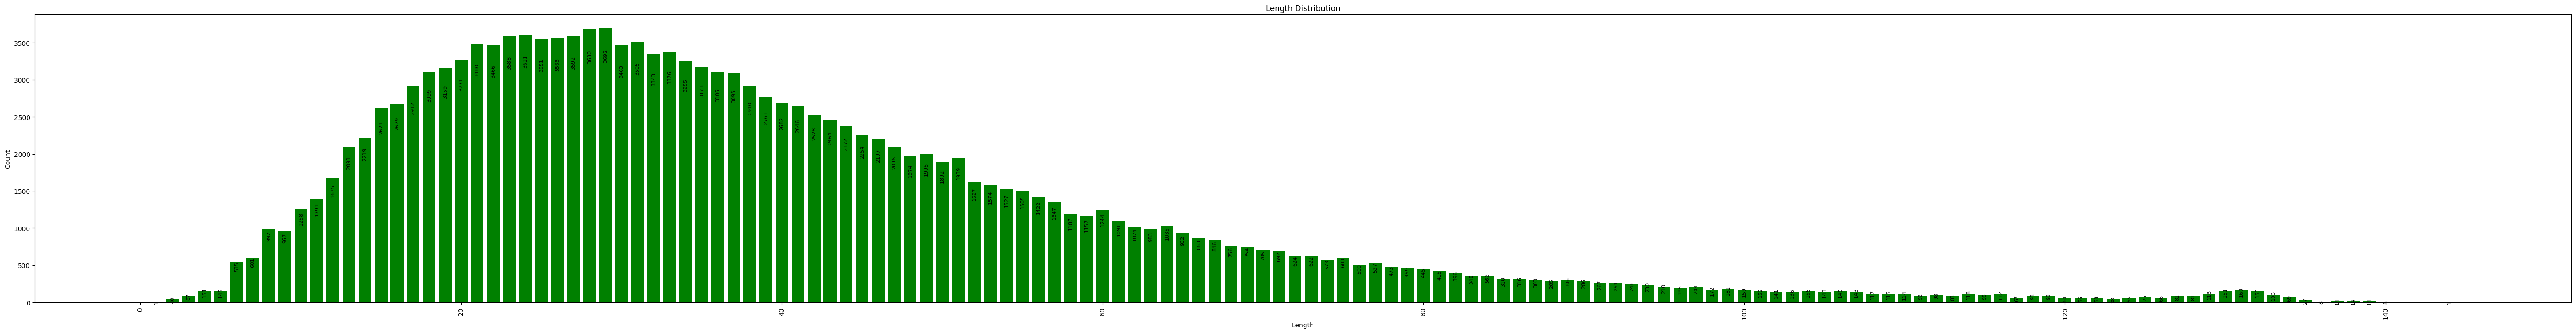

In [19]:
# Delete records with missing values in 'ProductName' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

In [20]:
# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()


Processing Rows: 100%|██████████| 157310/157310 [00:07<00:00, 21933.56 row/s]


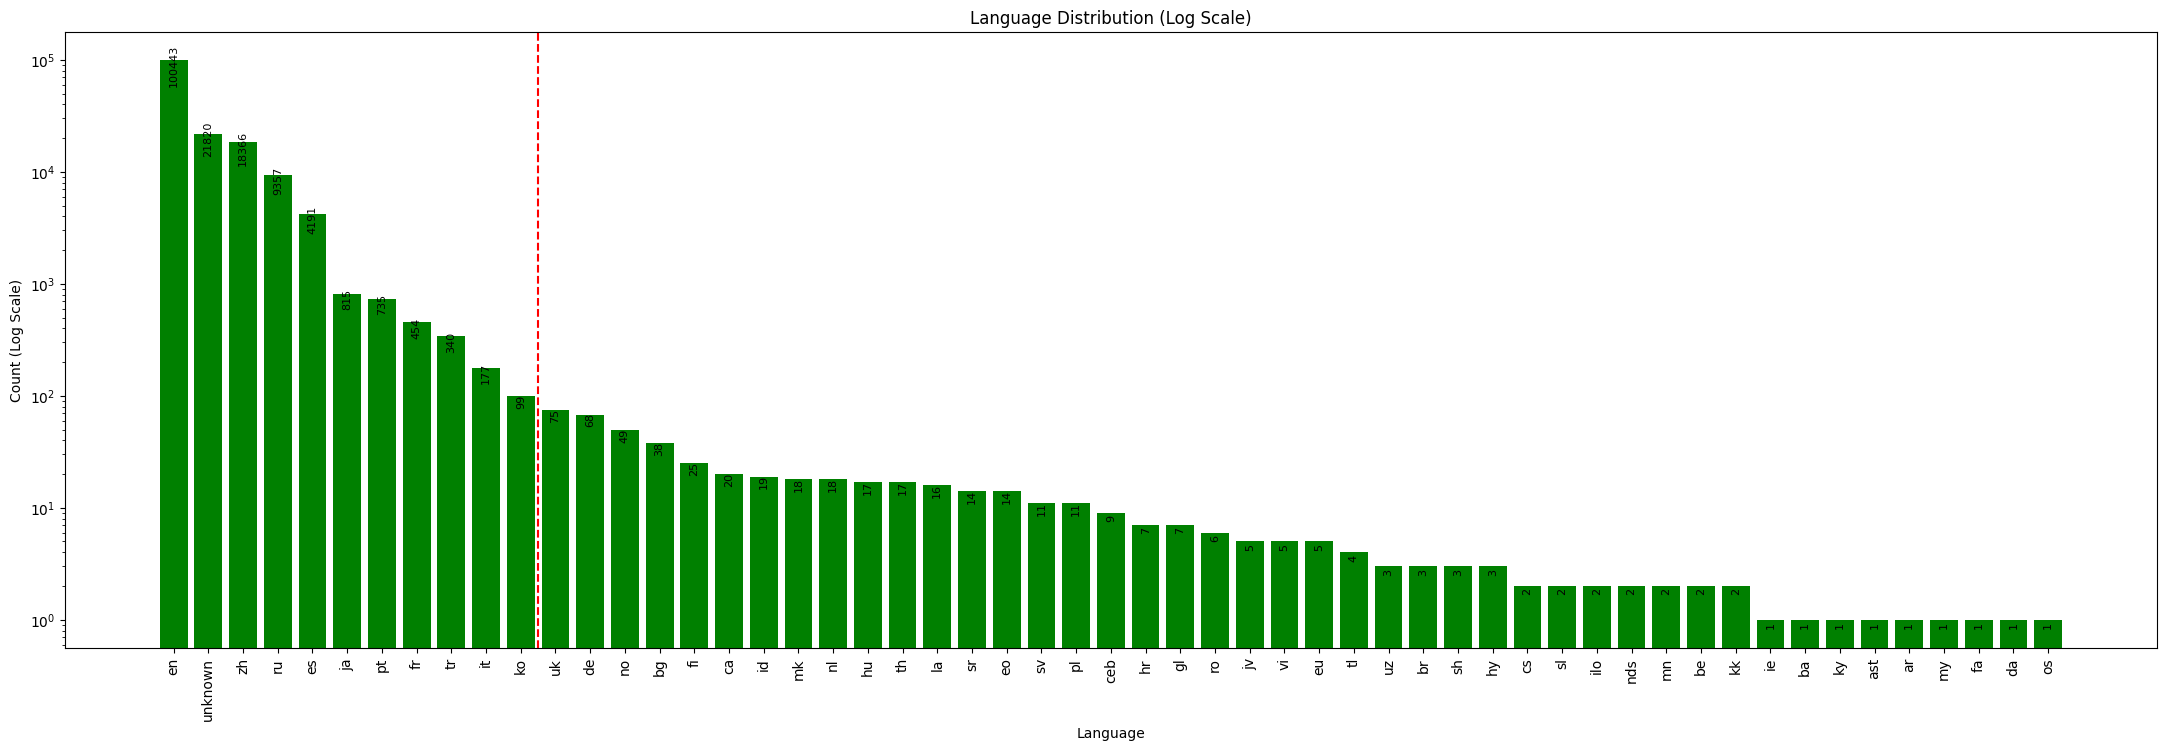

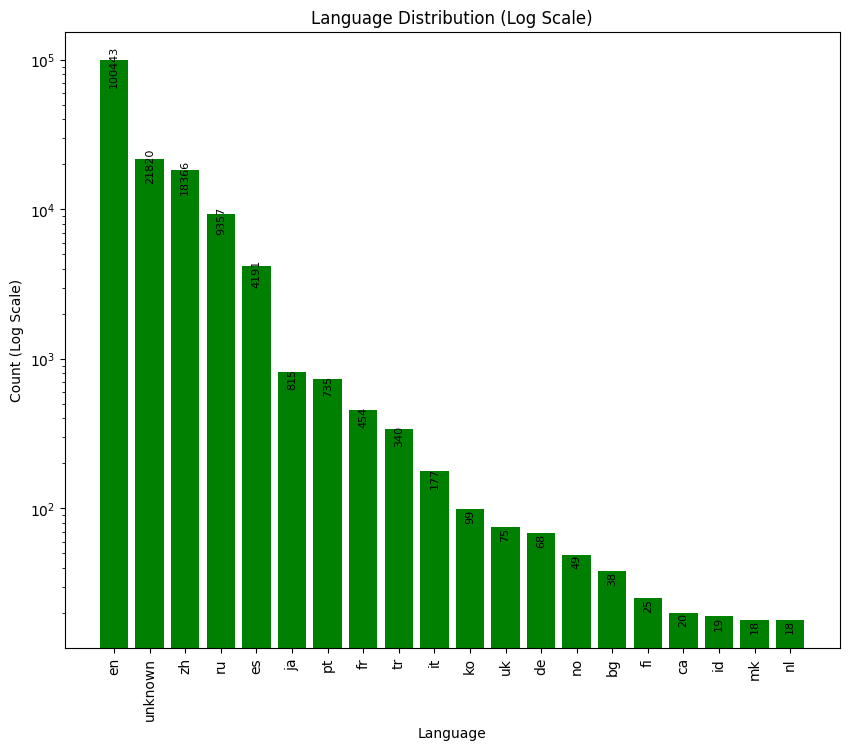

In [21]:
# fasttext performance is better than the other solutions for short text 
# (ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)
hist_by_labels(df_processed, "Language", top=20, log=True, horizontal=True)

In [22]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'

# Export the DataFrame to Excel
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Language Detection

In [23]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']
print(df_translated.info())
df_translated.head(-10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157310 entries, 0 to 157309
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             157310 non-null  int64         
 1   Title                  157310 non-null  object        
 2   Created Time           157310 non-null  datetime64[ns]
 3   Customer Company       157163 non-null  object        
 4   Customer Country       157250 non-null  object        
 5   Priority               157310 non-null  object        
 6   Urgency                157310 non-null  object        
 7   Impact                 157310 non-null  object        
 8   Product Name           157310 non-null  object        
 9   Service Definition     157302 non-null  object        
 10  Service Desk Group     156297 non-null  object        
 11  Status                 157310 non-null  object        
 12  Closed Time            154889 non-null  date

,Request ID,Title,Created Time,Customer Company,Customer Country,Priority,Urgency,Impact,Product Name,Service Definition,...,Closed Time,Response Time (Min),Resolution Time (Min),Contracts Reference,Creation Source,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1705753,OFM Support,2022-12-14 06:29:13,AL-KHAFJI JOINT OPERATIONS (AGOC/KGOC),NaN,P4 Low,This issue disrupts my work,Single user,OFM,Software Support,...,2022-12-29 06:30:58,0.0000,0.7150,Standard-Software-Maintenance-Contract,Agent Created Ticket,11,en,OFM Support,OFM Support,NaN
1,1130253,Rerun workflow and Create workflow option not ...,2022-01-04 21:52:01,GROUPEMENT REGGANE,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel RE,Software Support,...,2022-01-10 03:16:58,66.0677,0.0000,Standard-Software-Maintenance-Contract,Support Portal,55,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,NaN
2,1130330,[Ext] TR- Registration Completion Notice,2022-01-05 08:07:22,SH - PED,ALGERIA,P4 Low,This issue disrupts my work,Single user,ECLIPSE,Software Support,...,2022-01-21 08:27:25,37.6989,1402.1556,Standard-Software-Maintenance-Contract,Email,37,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,2022-01-05 14:29:47,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Other Requests,...,2022-01-05 14:32:14,0.0000,3.2456,Standard-Software-Maintenance-Contract,Agent Created Ticket,31,en,SH PED Patch Log for pro Source,SH PED Patch Log for pro Source,NaN
4,1131191,SH-PED: issue with ProSource services,2022-01-05 14:34:47,SH - PED,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,ProSource,Software Support,...,2022-01-05 14:36:32,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,37,en,SH PED issue with Pro Source services,SH PED issue with Pro Source services,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157295,1122257,How to run the python with other datasets,2021-12-28 10:17:26,PETROVIETNAM EXPLORATION AND PRODUCTION CORPOR...,VIET NAM,P4 Low,This issue disrupts my work,Single user,Techlog,Software Support,...,2021-12-30 07:39:30,0.0000,0.5320,Standard-Software-Maintenance-Contract,Phone,41,en,How to run the python with other datasets,How to run the python with other datasets,NaN
157296,1123293,Petrel: Flatten Well Tops in Well Section Window,2021-12-29 08:44:33,VIETSOVPETRO,VIET NAM,P4 Low,This issue disrupts my work,Single user,Petrel,Software Support,...,2021-12-30 06:08:08,0.6379,0.0000,Standard-DELFI-Service-Contract,Phone,47,en,Petrel Flatten Well Tops in Well Section Window,Petrel Flatten Well Tops in Well Section Window,NaN
157297,1123574,Petrel: Surface Attribute in Petrel,2021-12-29 08:46:21,PETROVIETNAM EXPLORATION AND PRODUCTION CORPOR...,VIET NAM,P4 Low,This issue disrupts my work,Single user,Petrel,Software Support,...,2021-12-30 06:25:47,0.4335,0.4522,Standard-Software-Maintenance-Contract,Phone,34,en,Petrel Surface Attribute in Petrel,Petrel Surface Attribute in Petrel,NaN
157298,1123849,Petrel: Merging Seismic Cube,2021-12-29 08:41:53,"SK INNOVATION CO., LTD.",VIET NAM,P4 Low,This issue disrupts my work,Single user,Petrel,Software Support,...,2021-12-30 06:07:16,0.9596,0.9778,Standard-Software-Maintenance-Contract,Phone,27,en,Petrel Merging Seismic Cube,Petrel Merging Seismic Cube,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 134977 entries, 0 to 157309
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             134977 non-null  int64         
 1   Title                  134977 non-null  object        
 2   Created Time           134977 non-null  datetime64[ns]
 3   Customer Company       134855 non-null  object        
 4   Customer Country       134929 non-null  object        
 5   Priority               134977 non-null  object        
 6   Urgency                134977 non-null  object        
 7   Impact                 134977 non-null  object        
 8   Product Name           134977 non-null  object        
 9   Service Definition     134972 non-null  object        
 10  Service Desk Group     134087 non-null  object        
 11  Status                 134977 non-null  object        
 12  Closed Time            132923 non-null  datetime6

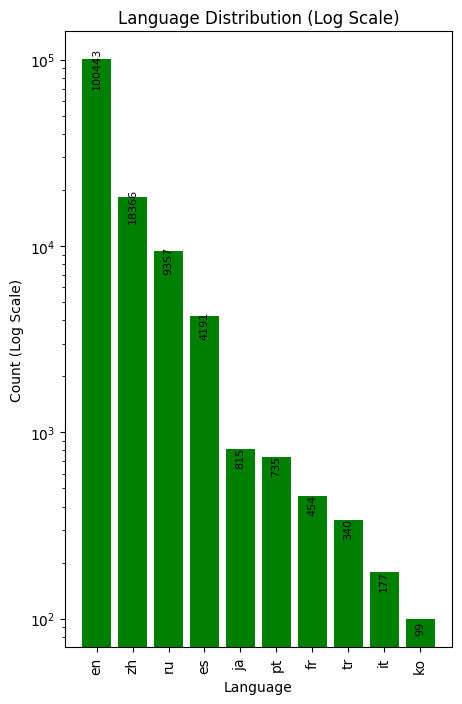

In [24]:
# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.

language_counts = df_translated['Language'].value_counts()
cutoff = 99
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_translated['Language'].isin(language_others)
df_translated.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_translated = df_translated[df_translated['Language'] != 'unknown']
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

## Translation of Non-English

In [25]:
# Group the DataFrame by the "Language" column
grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [{lang}/{len(group)}]")

    if lang != "en": # Skip English
        translated_titles = translate_array_to_english(
            group["Title_Translated"].tolist(),
            src_lang=lang,
            length_limit=1250)
        group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

Processing [zh/18366]: 100%|██████████| 10/10 [06:39<00:00, 39.95s/it]


Title_Cleaned            134977
Closed Time                2054
Service Desk Group          890
Customer Company            122
Customer Country             48
Service Definition            5
Contracts Reference           2
Resolution Time (Min)         0
Title_Translated              0
Title_Processed               0
Language                      0
Length                        0
Creation Source               0
Request ID                    0
Response Time (Min)           0
Title                         0
Product Name                  0
Impact                        0
Urgency                       0
Priority                      0
Created Time                  0
Status                        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134977 entries, 0 to 134976
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             134977 non-null  int64  

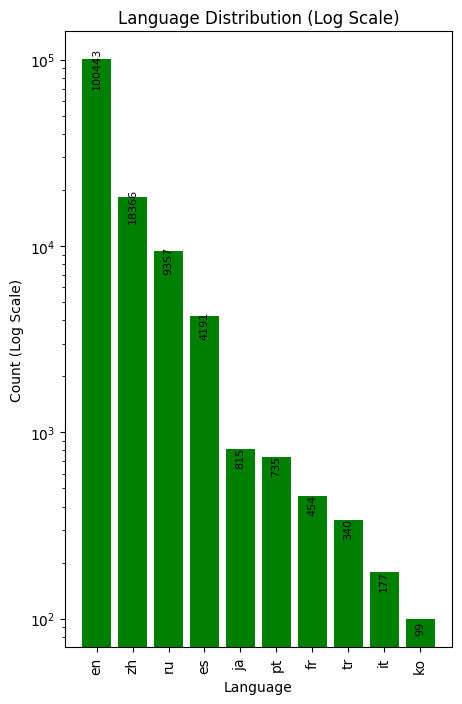

In [26]:
print(df_translated.isnull().sum().sort_values(ascending = False))

# Delete records with missing values in 'ProductName' columns
df_translated.dropna(subset=['Title_Translated'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_translated.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [27]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

# Export the DataFrame to Excel
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Final Clean up

In [28]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())
print(df_cleaned.info())
df_cleaned.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134977 entries, 0 to 134976
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             134977 non-null  object        
 1   Title                  134977 non-null  object        
 2   Created Time           134977 non-null  datetime64[ns]
 3   Customer Company       134855 non-null  object        
 4   Customer Country       134929 non-null  object        
 5   Priority               134977 non-null  object        
 6   Urgency                134977 non-null  object        
 7   Impact                 134977 non-null  object        
 8   Product Name           134977 non-null  object        
 9   Service Definition     134972 non-null  object        
 10  Service Desk Group     134087 non-null  object        
 11  Status                 134977 non-null  object        
 12  Closed Time            132923 non-null  date

,Request ID,Title,Created Time,Customer Company,Customer Country,Priority,Urgency,Impact,Product Name,Service Definition,...,Closed Time,Response Time (Min),Resolution Time (Min),Contracts Reference,Creation Source,Length,Language,Title_Processed,Title_Translated,Title_Cleaned
0,1705753,OFM Support,2022-12-14 06:29:13,AL-KHAFJI JOINT OPERATIONS (AGOC/KGOC),NaN,P4 Low,This issue disrupts my work,Single user,OFM,Software Support,...,2022-12-29 06:30:58,0.0000,0.7150,Standard-Software-Maintenance-Contract,Agent Created Ticket,11,en,OFM Support,OFM Support,NaN
1,1130253,Rerun workflow and Create workflow option not ...,2022-01-04 21:52:01,GROUPEMENT REGGANE,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel RE,Software Support,...,2022-01-10 03:16:58,66.0677,0.0000,Standard-Software-Maintenance-Contract,Support Portal,55,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,NaN
2,1130330,[Ext] TR- Registration Completion Notice,2022-01-05 08:07:22,SH - PED,ALGERIA,P4 Low,This issue disrupts my work,Single user,ECLIPSE,Software Support,...,2022-01-21 08:27:25,37.6989,1402.1556,Standard-Software-Maintenance-Contract,Email,37,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,2022-01-05 14:29:47,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Other Requests,...,2022-01-05 14:32:14,0.0000,3.2456,Standard-Software-Maintenance-Contract,Agent Created Ticket,31,en,SH PED Patch Log for pro Source,SH PED Patch Log for pro Source,NaN
4,1131191,SH-PED: issue with ProSource services,2022-01-05 14:34:47,SH - PED,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,ProSource,Software Support,...,2022-01-05 14:36:32,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,37,en,SH PED issue with Pro Source services,SH PED issue with Pro Source services,NaN
5,1131193,SH-PED: ProSource new License file,2022-01-05 14:38:53,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Software Support,...,2022-01-05 14:40:15,1.8040,1.8206,Standard-Software-Maintenance-Contract,Agent Created Ticket,34,en,SH PED Pro Source new License file,SH PED Pro Source new License file,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,2022-01-08 09:14:32,SH - DP - HMD,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,Delfi Portal,Software Support,...,2022-01-24 18:17:23,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,40,en,Schlumberger Licensing Tool not starting,Schlumberger Licensing Tool not starting,NaN
7,1135119,Production by zone/segment,2022-01-09 21:26:38,ALNAFT,ALGERIA,P3 Medium,This issue partially blocks my work,Single user,Petrel RE,Software Support,...,2022-01-25 07:27:22,0.0000,0.0000,Standard-Software-Maintenance-Contract,Support Portal,26,en,Production by zone segment,Production by zone segment,NaN
8,1136751,data exchanger with client,2022-01-10 09:47:01,SONATRACH DIVISION PRODUCTION,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel,Software Support,...,2022-01-18 10:07:20,0.1846,4234.9140,Standard-Software-Maintenance-Contract,Agent Created Ticket,26,en,data exchanger with client,data exchanger with client,NaN
9,1140517,"Error: Unable to start external queue, but run...",2022-01-12 16:03:12,GROUPEMENT REGGANE,ALGERIA,P3 Medium,I am blocked from doing my job,Single user,Petrel RE,Software Support,...,2022-01-20 15:52:23,208.3179,6875.1180,Standard-Software-Maintenance-Contract,Support Portal,56,en,Error Unable to start external queue but runni...,Error Unable to start external queue but runni...,NaN


In [29]:
df_cleaned.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Set the number of rows to process
num = df_cleaned['Title_Translated'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Title_Cleaned'] = final_clean_up(df_cleaned.at[index, 'Title_Translated'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Cleaned'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

print(df_cleaned.info())

Processing Rows: 100%|█████████▉| 134725/134977 [00:20<00:00, 6648.39 row/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134977 entries, 0 to 134976
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        134977 non-null  object
 1   Title             134977 non-null  object
 2   Product Name      134977 non-null  object
 3   Length            134977 non-null  int64 
 4   Language          134977 non-null  object
 5   Title_Processed   134977 non-null  object
 6   Title_Translated  134977 non-null  object
 7   Title_Cleaned     134725 non-null  object
dtypes: int64(1), object(7)
memory usage: 8.2+ MB
None


In [30]:
# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Title_Cleaned'], inplace=True)
df_cleaned.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Title_Cleaned'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Title_Cleaned'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
Index: 134725 entries, 3 to 134976
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        134725 non-null  object
 1   Title             134725 non-null  object
 2   Product Name      134725 non-null  object
 3   Length            134725 non-null  int64 
 4   Language          134725 non-null  object
 5   Title_Processed   134725 non-null  object
 6   Title_Translated  134725 non-null  object
 7   Title_Cleaned     134725 non-null  object
dtypes: int64(1), object(7)
memory usage: 9.3+ MB
None
115663
<class 'pandas.core.frame.DataFrame'>
Index: 115663 entries, 3 to 134976
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115663 non-null  object
 1   Title             115663 non-null  object
 2   Product Name      115663 non-null  object
 3   Length            

In [31]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'

# Export the DataFrame to Excel
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Training

## Prepare Data for Modeling

### Load Cleaned Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115663 entries, 0 to 115662
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115663 non-null  int64 
 1   Title             115663 non-null  object
 2   Product Name      115663 non-null  object
 3   Length            115663 non-null  int64 
 4   Language          115663 non-null  object
 5   Title_Processed   115663 non-null  object
 6   Title_Translated  115663 non-null  object
 7   Title_Cleaned     115663 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.1+ MB
None


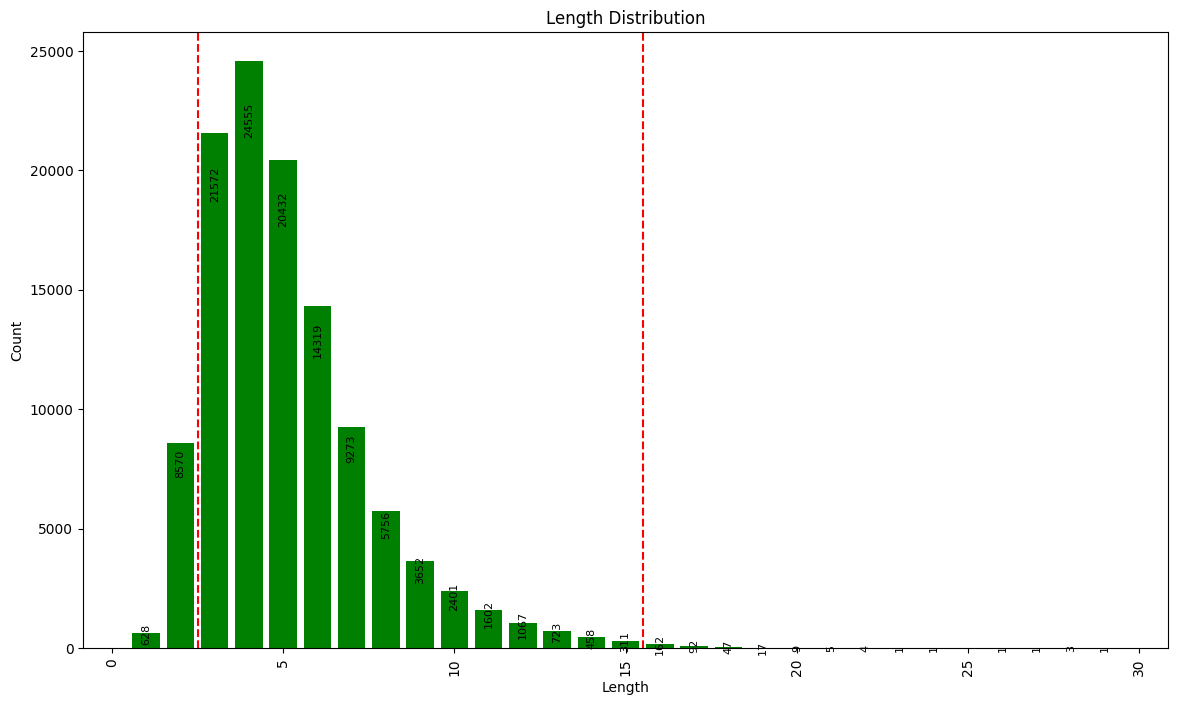

In [32]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file)
print(df_cleaned.info())
hist_by_labels(df_cleaned, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

### Remove short Titles

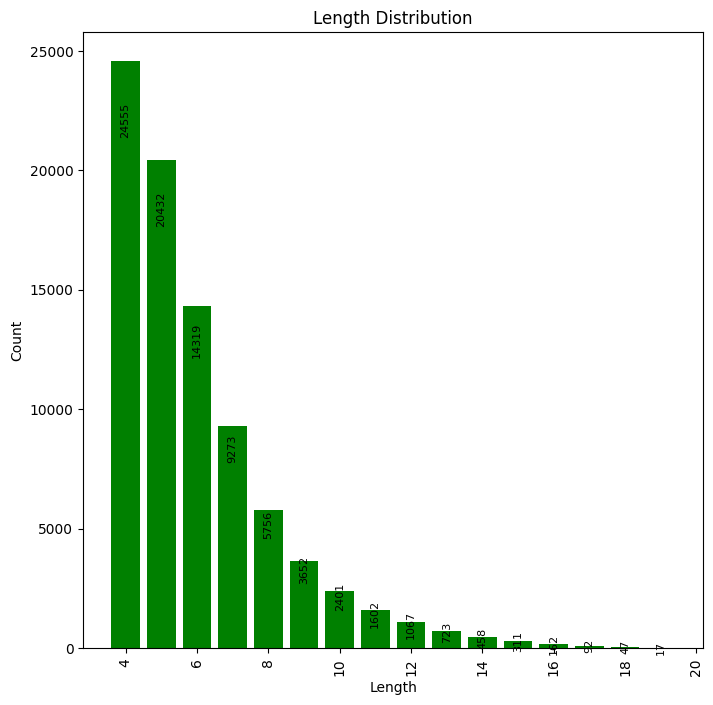

In [33]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_cleaned['Length'] > 3) & (df_cleaned['Length'] < 20)
df_cleaned = df_cleaned[mask]
hist_by_labels(df_cleaned, 'Length', horizontal=True)

### Combine the long tail into Others

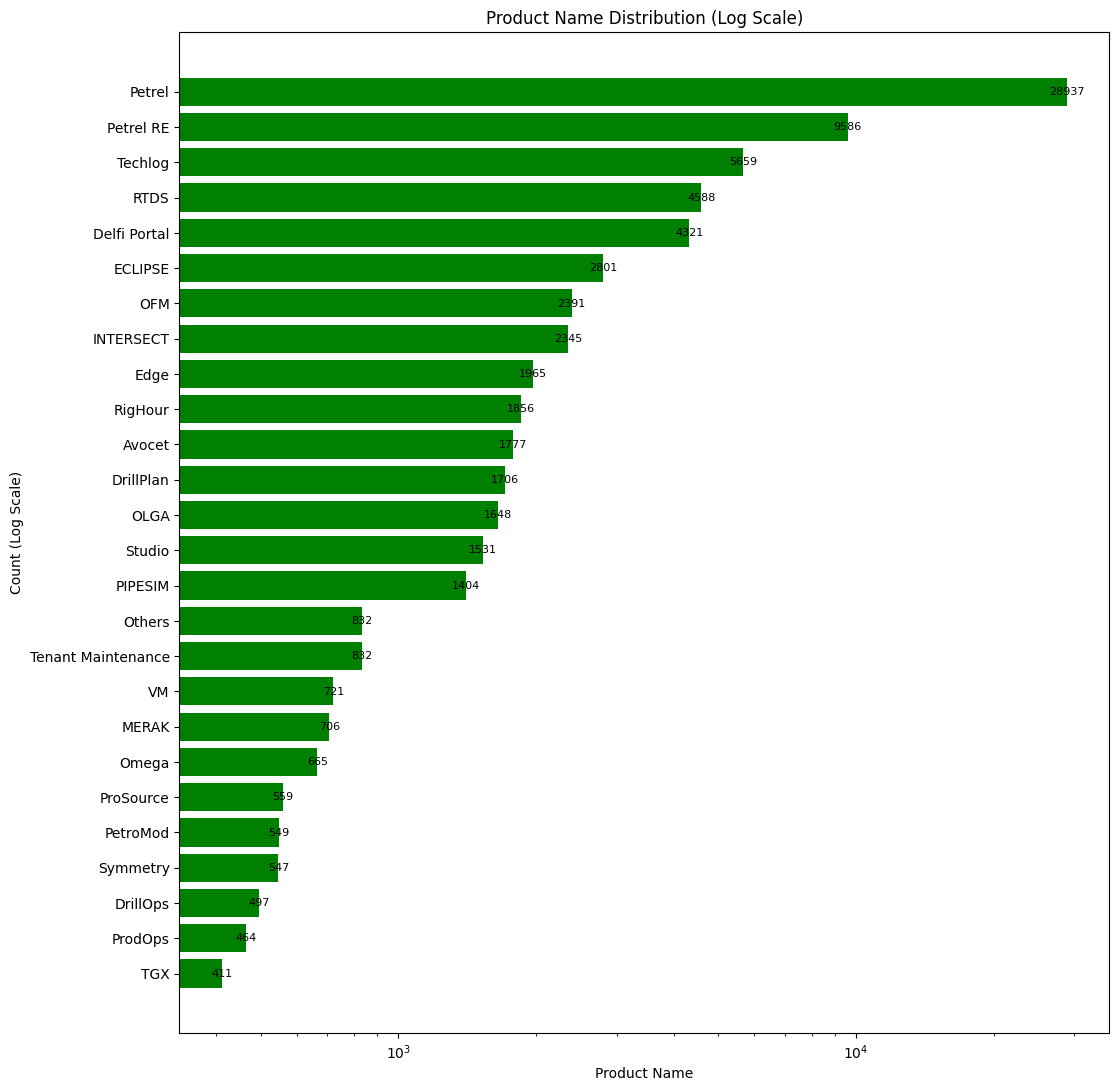

In [34]:
hist_by_labels(df_cleaned, 'Product Name', top=26, log=True, horizontal=False)

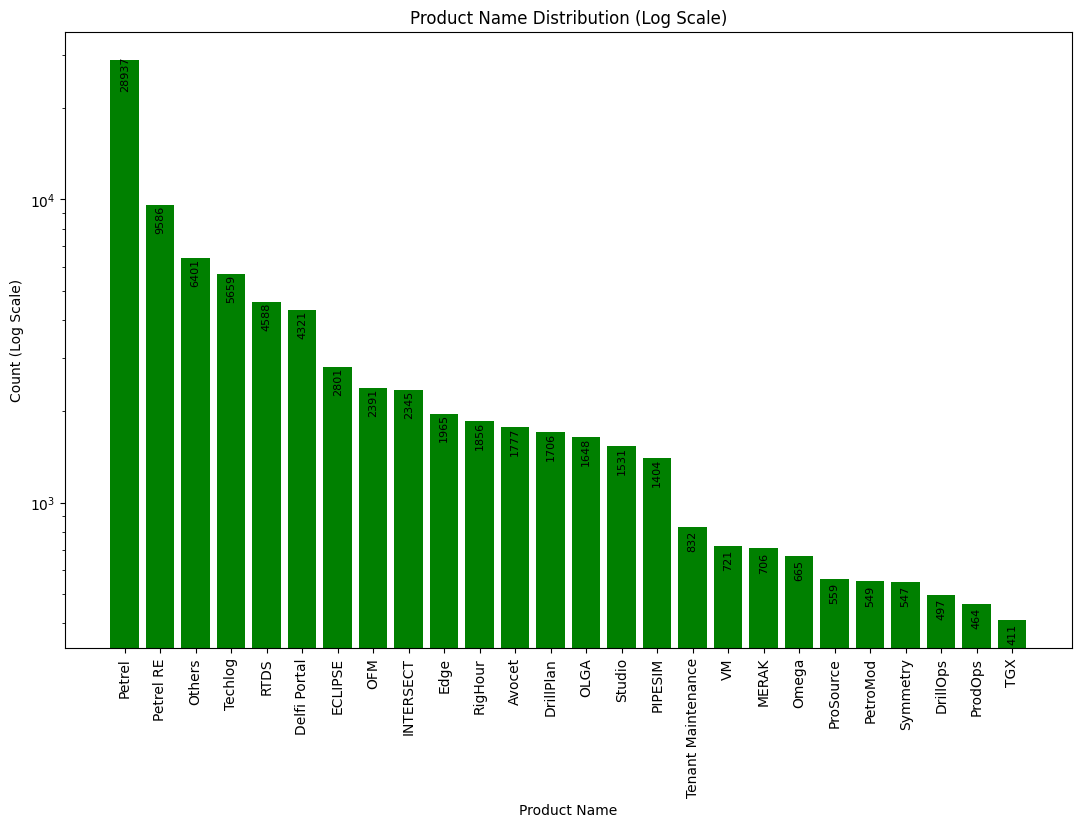

In [35]:
# Keep the top 50 products and combine the rest into 'Others'
product_counts = df_cleaned['Product Name'].value_counts()
cutoff = 400
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_cleaned['Product Name'].isin(product_others)
df_cleaned.loc[mask_others,'Product Name']='Others'
hist_by_labels(df_cleaned, 'Product Name', log=True)

### Train/Test Split

<class 'pandas.core.frame.DataFrame'>
Index: 43429 entries, 52448 to 71274
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        43429 non-null  int64 
 1   Title             43429 non-null  object
 2   Product Name      43429 non-null  object
 3   Length            43429 non-null  int64 
 4   Language          43429 non-null  object
 5   Title_Processed   43429 non-null  object
 6   Title_Translated  43429 non-null  object
 7   Title_Cleaned     43429 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 41438 entries, 2073 to 115620
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        41438 non-null  int64 
 1   Title             41438 non-null  object
 2   Product Name      41438 non-null  object
 3   Length            41438 non-null  in

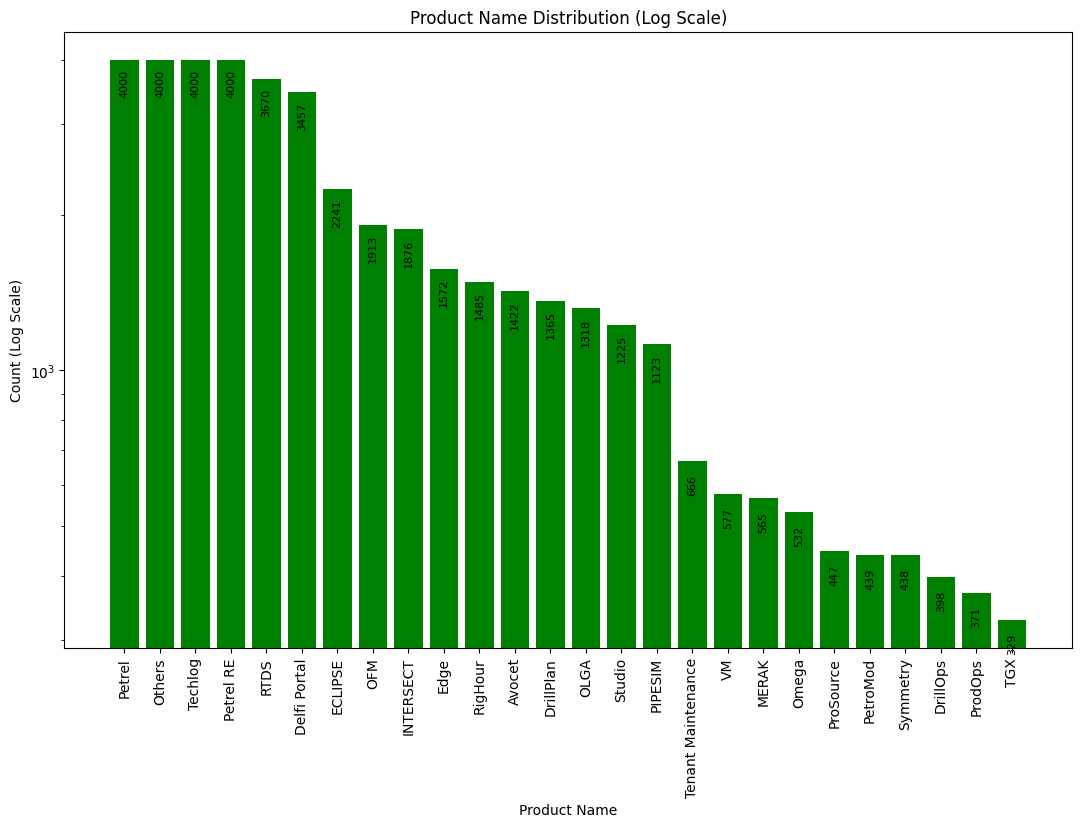

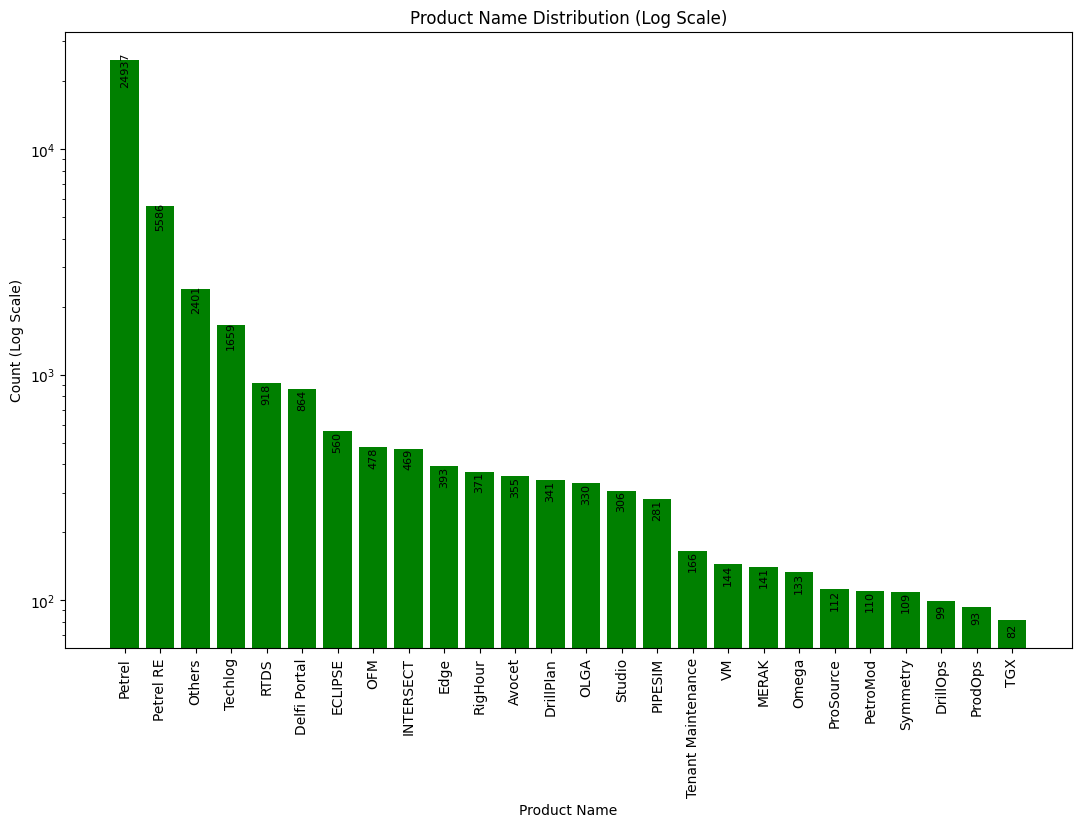

In [36]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
df_cleaned_balanced = pd.DataFrame()
df_cleaned_test = pd.DataFrame()
for product in df_cleaned['Product Name'].unique():
    df_product = df_cleaned[df_cleaned['Product Name'] == product]
    if df_product.shape[0] > 5000:
        df_product_balanced = df_product.sample(4000).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])
    else:
        df_product_balanced = df_product.sample(frac=0.8).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])

print(df_cleaned_balanced.info())
print(df_cleaned_test.info())

hist_by_labels(df_cleaned_balanced, 'Product Name', log=True)
hist_by_labels(df_cleaned_test, 'Product Name', log=True)

In [37]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = df_cleaned['Title_Cleaned']
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

X_train = df_cleaned_balanced['Title_Cleaned']
X_train_encoded = vectorizer.transform(X_train)
y_train = df_cleaned_balanced['Product Name']

X_test = df_cleaned_test['Title_Cleaned']
X_test_encoded = vectorizer.transform(X_test)
y_test = df_cleaned_test['Product Name']

## Model Baseline - Cross Validation

In [38]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [39]:
models = {
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'SVC rbf': SVC(kernel='rbf'),
    'SVC linear': SVC(kernel='linear'),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'XGBClassifier': xgb.XGBClassifier()
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded, # please provide the features after preprocessing
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.7223 by MultinomialNB.
Average score: 0.7560 by SGDClassifier.
Average score: 0.7499 by LogisticRegression.
Average score: 0.7328 by SVC rbf.
Average score: 0.7317 by SVC linear.


# Hpyerparameter Tuning

## SGC Classifier

In [40]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-18 22:09:25,659] A new study created in memory with name: no-name-566b6ee3-91ba-4716-9fab-2bfa1fd26b68


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-18 22:09:29,546] Trial 7 finished with value: 0.7496143252112897 and parameters: {'loss': 'modified_huber', 'alpha': 0.00038079684025922773, 'penalty': 'l2'}. Best is trial 7 with value: 0.7496143252112897.
[I 2023-10-18 22:09:30,063] Trial 4 finished with value: 0.6184115599172882 and parameters: {'loss': 'modified_huber', 'alpha': 0.09418426581937238, 'penalty': 'l2'}. Best is trial 7 with value: 0.7496143252112897.
[I 2023-10-18 22:09:30,150] Trial 6 finished with value: 0.0905844925979524 and parameters: {'loss': 'log_loss', 'alpha': 8.886309981141844, 'penalty': 'l1'}. Best is trial 7 with value: 0.7496143252112897.
[I 2023-10-18 22:09:30,317] Trial 2 finished with value: 0.0905844925979524 and parameters: {'loss': 'log_loss', 'alpha': 19.48916310654299, 'penalty': 'l1'}. Best is trial 7 with value: 0.7496143252112897.
[I 2023-10-18 22:09:30,586] Trial 9 finished with value: 0.44481884240960545 and parameters: {'loss': 'modified_huber', 'alpha': 4.241117144036902, 'pena

                    precision    recall  f1-score   support

            Avocet      0.598     0.775     0.675       355
      Delfi Portal      0.308     0.694     0.426       864
          DrillOps      0.786     0.667     0.721        99
         DrillPlan      0.597     0.804     0.685       341
           ECLIPSE      0.291     0.579     0.387       560
              Edge      0.972     0.982     0.977       393
         INTERSECT      0.369     0.655     0.472       469
             MERAK      0.929     0.837     0.881       141
               OFM      0.834     0.839     0.836       478
              OLGA      0.878     0.788     0.831       330
             Omega      0.893     0.820     0.855       133
            Others      0.525     0.577     0.550      2401
           PIPESIM      0.797     0.783     0.790       281
            Petrel      0.955     0.790     0.865     24937
         Petrel RE      0.662     0.632     0.647      5586
          PetroMod      0.580     0.755

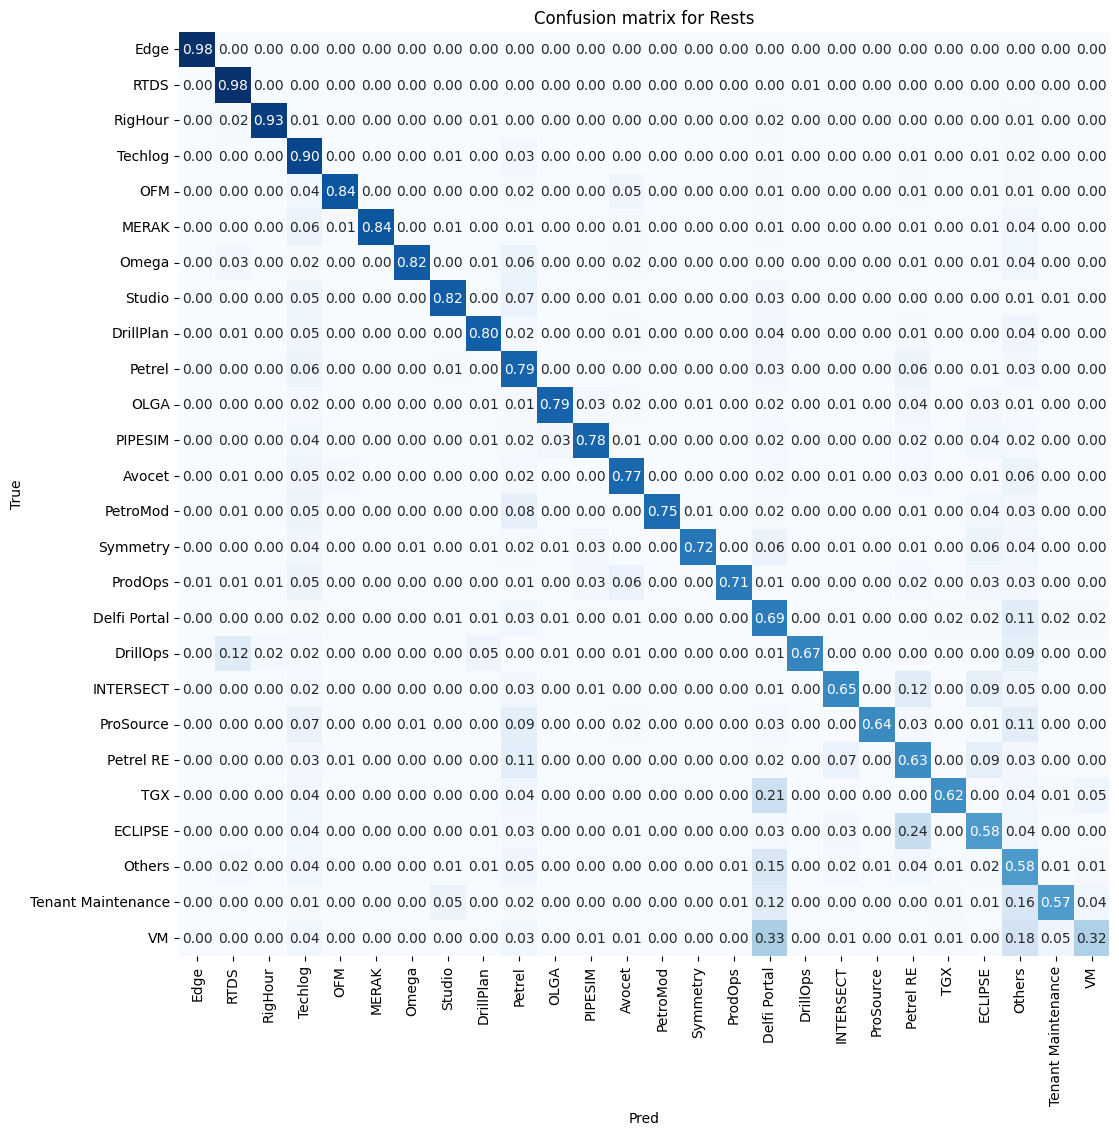

Accuracy of top 1 prediction is 0.759.
Accuracy of top 3 prediction is 0.926.
Accuracy of top 5 prediction is 0.955.


In [41]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [43]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

Accuracy: 0.752
                    precision    recall  f1-score   support

            Avocet      0.598     0.800     0.684       355
      Delfi Portal      0.292     0.656     0.404       864
          DrillOps      0.762     0.646     0.699        99
         DrillPlan      0.588     0.815     0.683       341
           ECLIPSE      0.270     0.575     0.367       560
              Edge      0.980     0.982     0.981       393
         INTERSECT      0.351     0.640     0.454       469
             MERAK      0.912     0.809     0.857       141
               OFM      0.825     0.849     0.837       478
              OLGA      0.840     0.782     0.810       330
             Omega      0.918     0.842     0.878       133
            Others      0.488     0.586     0.532      2401
           PIPESIM      0.714     0.772     0.742       281
            Petrel      0.959     0.778     0.859     24937
         Petrel RE      0.635     0.646     0.641      5586
          PetroMod     

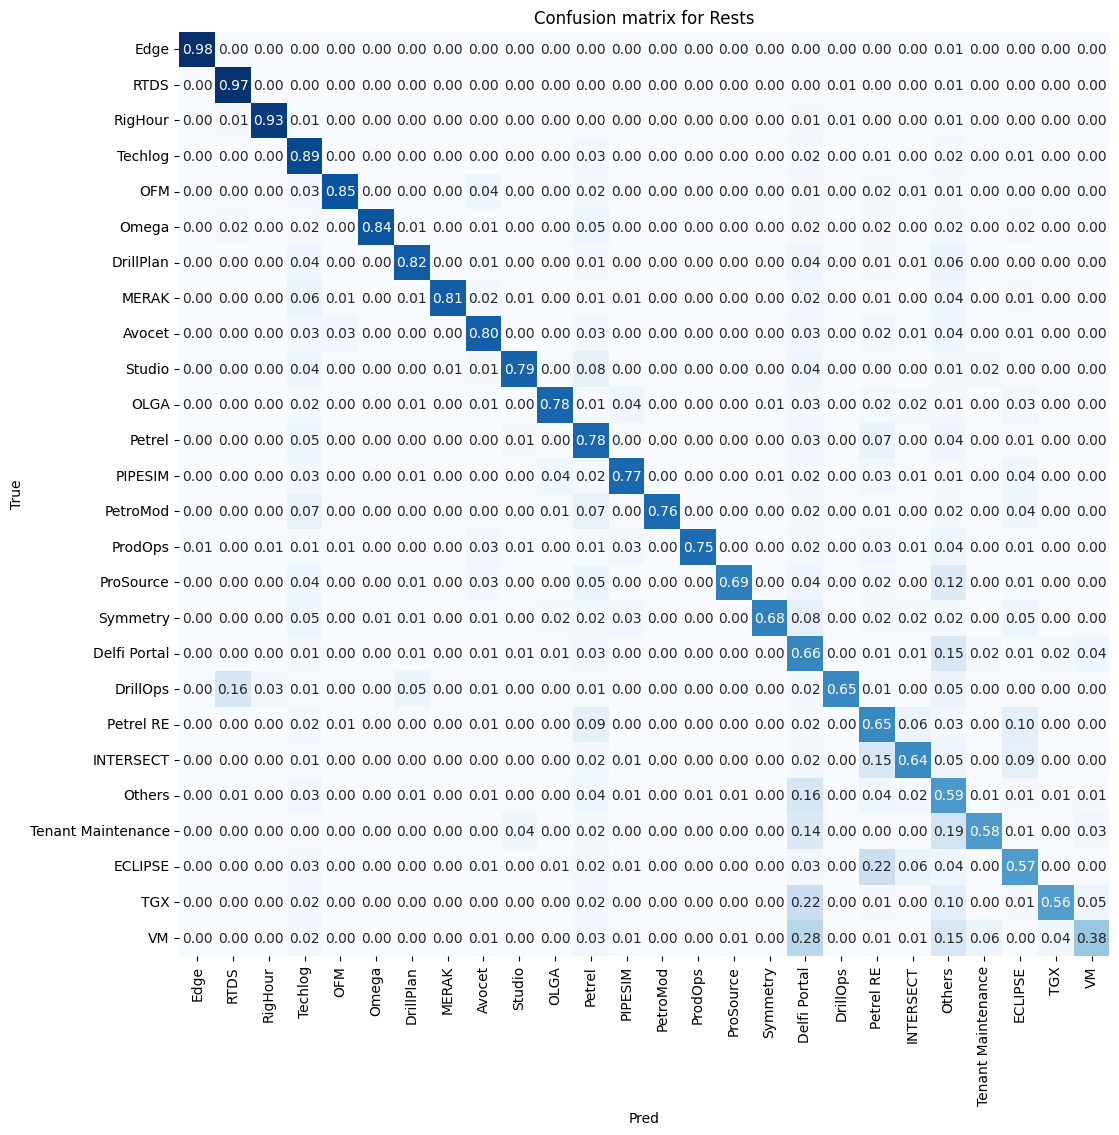

Accuracy of top 1 prediction is 0.752.
Accuracy of top 3 prediction is 0.934.
Accuracy of top 5 prediction is 0.970.


In [44]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_logReg = LogisticRegression(
    max_iter=5000,
    # class_weight= weights
)
model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=300, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer, X_test, y_test, pre_processed=True)